# Integrating Orbits in a moving frame

This recipe is a minimum working example for integrating orbits in a moving frame. We will
1. Build the basis and coefficients from scratch
2. Implement a moving basis
3. Integrate orbits in the inertial frame

In [1]:
# some preliminaries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import pyEXP
import pyEXP

if "Version" in dir(pyEXP.util):
    # check the version
    #pyEXP.util.getVersionInfo() # this is a more exhaustive printout for diagnostics
    current_version = pyEXP.util.Version()

    required_version = (7, 8, 3)

    if current_version < required_version:
        raise RuntimeError(f"EXP version {required_version} or higher is required, found {current_version}.")
else:
    raise RuntimeError(f"EXP version >= 7.8.3 is required for this example.")

In [3]:
lmax,nmax = 4,10

bconfig = """
---
id: sphereSL
parameters :
  numr: 2000
  rmin: 0.0001
  rmax: 1.95
  Lmax: {}
  nmax: {}
  rmapping: 0.0667
  modelname: SLGridSph.model
  cachename: sphereSL.cache
...
""".format(lmax,nmax)

# Construct the basis instance
#
halo_basis   = pyEXP.basis.Basis.factory(bconfig)

---- SLGridSph::ReadH5Cache: successfully read basis cache <sphereSL.cache>
---- Spherical::orthoTest: worst=0.00016446


In [4]:
# now make a custom array of complex coefficients to install
lnumber = int((lmax+1)*(lmax+2)/2)
halo_coef_matrix = np.zeros([lnumber,nmax], dtype=np.complex128)

# set just the lowest-order term
halo_coef_matrix[0,0]=1.0


In [5]:
# make dummy coefficients for this basis to test orbits
halo_coef = halo_basis.createFromArray([1.],[[1.],[1.],[1.]], time=0.0)
halo_coefs = pyEXP.coefs.Coefs.makecoefs(halo_coef, 'halo')

# check the time and center
print('Time:', halo_coef.getCoefTime())
print('Center:', halo_coef.getCoefCenter())

# the time and the center can be overridden here
halo_coef.setCoefTime(0.0) # the time can be overridden here
halo_coef.setCoefCenter([0.,0.,0.]) # the center can be overridden here
halo_coef.assign(halo_coef_matrix,lmax,nmax) # note that `assign` takes a matrix, even though getCoefs() returns a flattened vector

halo_coefs.add(halo_coef)
!rm outcoef.linearorbit.halo
halo_coefs.WriteH5Coefs('outcoef.linearorbit.halo')


Time: 0.0
Center: [0.0, 0.0, 0.0]


Now let's duplicate those coefficients at a time in the future, but in a different location.

In [6]:

halo_coef = halo_basis.createFromArray([1.],[[1.],[1.],[1.]], time=0.0, center=[3.,0.,0.])
halo_coef.assign(halo_coef_matrix,lmax,nmax)

# pick a time way in the future...
halo_coef.setCoefTime(200.0)

# add the coefficients to the makecoefs instance
halo_coefs.add(halo_coef)
halo_coefs.ExtendH5Coefs('outcoef.linearorbit.halo')


Once the file is generated, we can read it back in going forward to save time.

In [7]:
cfile = 'outcoef.linearorbit.halo'
halo_coefs = pyEXP.coefs.Coefs.factory(cfile)

# let's check the centers after reading the file back in
print('T=0 center:',halo_coefs.getCoefStruct(0.0).getCoefCenter())
print('T=200 center:',halo_coefs.getCoefStruct(200.0).getCoefCenter())

T=0 center: [0.0, 0.0, 0.0]
T=200 center: [3.0, 0.0, 0.0]


In [8]:
# now we should have the ingredients that we need to integrate: a basis and a set of coefficients

# pick a phase space for some orbit:
ps = [[0.25,0,0,0,0.5,0.0]]

# set up the model with the basis and coefficients
model = [[halo_basis,halo_coefs]]

# set up a basic acceleration integration
func = pyEXP.basis.AllTimeAccel()

start_time,end_time,dt = 0.0,200.0,0.01
# integrate the orbit
times, orbits = pyEXP.basis.IntegrateOrbits(start_time, end_time, dt, ps, model, func)

Text(0, 0.5, 'y')

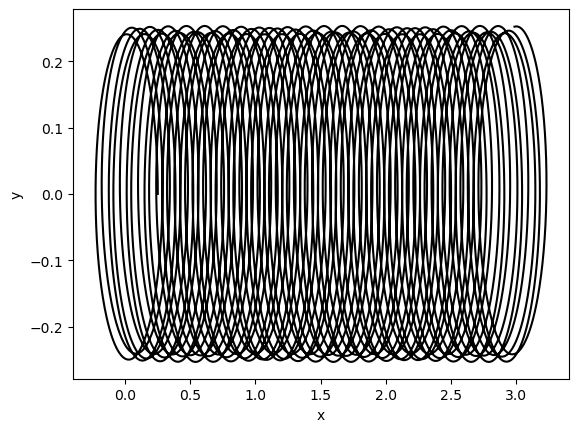

In [9]:
plt.plot(orbits[0][0,:],orbits[0][1,:],color='black')
plt.xlabel('x')
plt.ylabel('y')

How did I pick those ICs? I used the circular velocity curve as a guide to find an orbit with some eccentricity (but not too much).

[0.0]
2000 1


Text(0, 0.5, 'circular velocity')

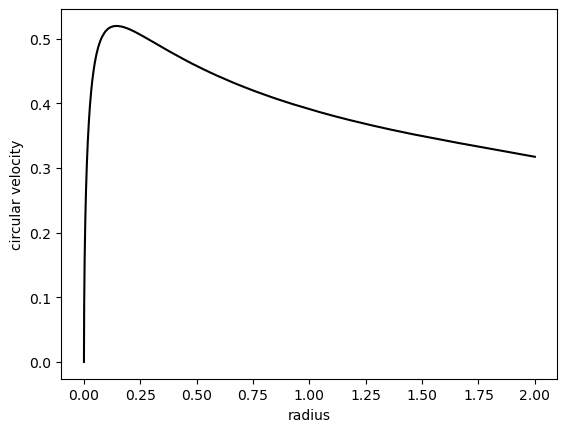

In [10]:
# make a circular velocity curve to get a velocity sense
pmin  = [0.0, 0.0, 0.0]
pmax  = [2.0, 0.0, 0.0]

# grid samples (sliced because last index is 0)
grid  = [2000,  0, 1]

indx = 0
times = [0.0]
print(times)
fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid) # note: this is always in the frame of the basis
surfaces = fields.slices(halo_basis, halo_coefs)

# Get the shape
keys = list(surfaces.keys())
nx = surfaces[keys[0]]['dens'].shape[0]
ny = surfaces[keys[0]]['dens'].shape[1]
print(nx,ny)

v = keys[0]
mapvals = surfaces[v]['rad force']#/surfaces0[v0]['dens m=0']
radii = np.linspace(0.0, 2.0, nx)
plt.plot(radii,np.sqrt(radii*np.abs(surfaces[v]['rad force'][:,0])),color='black')
plt.xlabel('radius')
plt.ylabel('circular velocity')

We can do the same thing, but with the basis on a circular orbit, by sampling the coefficients more frequenctly.

In [11]:
# set up the same initial timestep
halo_coef = halo_basis.createFromArray([1.],[[1.],[1.],[1.]], time=0.0)
halo_coefs = pyEXP.coefs.Coefs.makecoefs(halo_coef, 'halo')

# check the time and center
print('Time:', halo_coef.getCoefTime())
print('Center:', halo_coef.getCoefCenter())

t = 0.0
orbitradius=2.0
orbitfrequency = (2.*np.pi)/200.0
# the time and the center can be overridden here
halo_coef.setCoefTime(t) # the time can be overridden here
halo_coef.setCoefCenter([orbitradius*np.cos(orbitfrequency*t),orbitradius*np.sin(orbitfrequency*t),0.]) # the center can be overridden here
halo_coef.assign(halo_coef_matrix,lmax,nmax) # note that `assign` takes a matrix, even though getCoefs() returns a flattened vector

halo_coefs.add(halo_coef)
!rm outcoef.circularorbit.halo
halo_coefs.WriteH5Coefs('outcoef.circularorbit.halo')


Time: 0.0
Center: [0.0, 0.0, 0.0]


In [12]:
# now we can repeat the process for lots of time steps
totaltime = 200.0
dt = 0.25
nsteps = int(totaltime/dt)+1
print('setting up {} steps'.format(nsteps))

# the 0th step is already done!
for n in range(1,nsteps):
    t = n*dt
    #print(t)
    #halo_coef = halo_basis.createFromArray([1.],[[1.],[1.],[1.]], time=0.0, center=[0.,0.,0.])
    halo_coef = halo_coef.deepcopy()
    halo_coef.assign(halo_coef_matrix,lmax,nmax)
    halo_coef.setCoefTime(t) # the time can be overridden here
    halo_coef.setCoefCenter([orbitradius*np.cos(orbitfrequency*t),orbitradius*np.sin(orbitfrequency*t),0.]) # the center can be overridden here
    halo_coefs.add(halo_coef)
    halo_coefs.ExtendH5Coefs('outcoef.circularorbit.halo')

setting up 801 steps


Text(0, 0.5, 'basis y center')

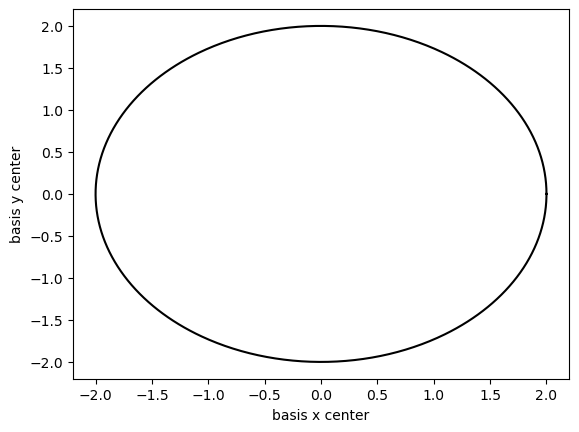

In [13]:
cfile = 'outcoef.circularorbit.halo'
halo_coefs = pyEXP.coefs.Coefs.factory(cfile)

xcen = np.array([halo_coefs.getCoefStruct(t).getCoefCenter()[0] for t in halo_coefs.Times()])
ycen = np.array([halo_coefs.getCoefStruct(t).getCoefCenter()[1] for t in halo_coefs.Times()])
plt.plot(xcen,ycen,color='black')
plt.xlabel('basis x center')
plt.ylabel('basis y center')

Text(0, 0.5, 'y')

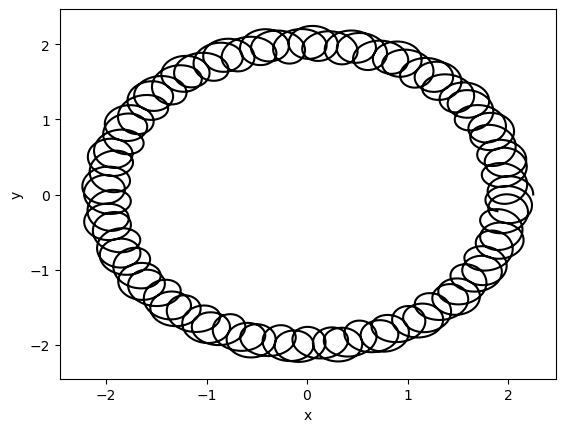

In [14]:
# now we should have the ingredients that we need to integrate: a basis and a set of coefficients

# pick a phase space for some orbit:
ps = [[2.25,0,0,0,0.5,0.0]]

# set up the model with the basis and coefficients
model = [[halo_basis,halo_coefs]]

# set up a basic acceleration integration
func = pyEXP.basis.AllTimeAccel()

start_time,end_time,dt = 0.0,200.0,0.01
# integrate the orbit
times, orbits = pyEXP.basis.IntegrateOrbits(start_time, end_time, dt, ps, model, func)

plt.plot(orbits[0][0,:],orbits[0][1,:],color='black')
plt.xlabel('x')
plt.ylabel('y')

We can do the same thing, but with a custom force function:

In [15]:
# Derive a new class from the C++ base class
#
import bisect

class OrbitingBasis(pyEXP.basis.AccelFunc):
    def __init__(self):
        pyEXP.basis.AccelFunc.__init__(self)  # Without this, a TypeError is raised.
        print(type(self))
    def evalcoefs(self, t, mod):
        # For convenience
        #
        basis = mod[0]   # Get the basis instance
        coefs = mod[1]   # Get the coefs instance
        times = coefs.Times()  # Get the time array
        # Make sure that the times are in the range of the coefficient db
        #
        if t<times[0] or t>times[-1]:
            raise ValueError("Time must be in the range [{}, {}]".format(times[0], times[-1]))
        # Find the lower bound poisition
        #
        pos = bisect.bisect_left(coefs.Times(), t)
        # Deal with end point issues
        #
        if pos>len(times)-2: pos = len(times)-2
        # Now for the linear interpolation
        #
        a = (times[pos+1] - t)/(times[pos+1] - times[pos])
        b = (t - times[pos])/(times[pos+1] - times[pos])
        coefA = coefs.getCoefStruct(times[pos])
        coefB = coefs.getCoefStruct(times[pos+1])
        coefT = coefA.deepcopy() # Copy one of the structs
        # Assign new data
        coefT.setCoefTime(t)
        
        # One can assign data to the map from setCoefs but
        # getCoefs() is read-only
        #
        C = coefT.setCoefs()
        
        # This is a direct write to the coefficients
        C = a*coefA.getCoefs() + b*coefB.getCoefs()
        #coefT.setCoefCenter(a*np.array(coefA.getCoefCenter()) + b*np.array(coefB.getCoefCenter()))

        # set the center to be on a circular orbit
        coefT.setCoefCenter([orbitradius*np.cos(orbitfrequency*t),orbitradius*np.sin(orbitfrequency*t),0.])

        # Sanity check
        test = np.linalg.norm(coefA.getCoefs() - coefT.getCoefs())
        if test > 1.0e-16: print(test, a, b)
        
       
        # Install the coefficients in the basis
        basis.set_coefs(coefT)

<class '__main__.OrbitingBasis'>


Text(0, 0.5, 'y')

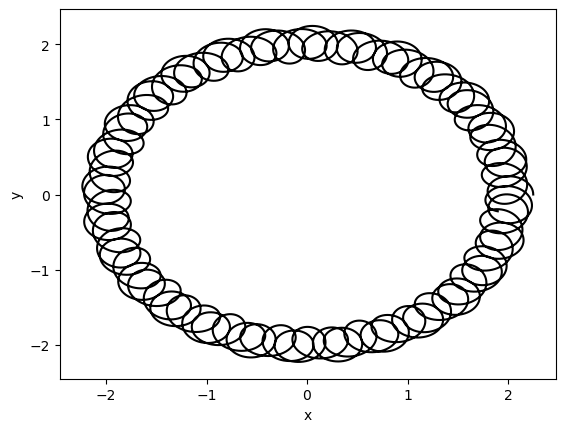

In [16]:
# now we should have the ingredients that we need to integrate: a basis and a set of coefficients

# pick a phase space for some orbit:
ps = [[2.25,0,0,0,0.5,0.0]]

# set up the model with the basis and coefficients
# we can hack it with te linear orbits now!
cfile = 'outcoef.linearorbit.halo'
halo_coefs = pyEXP.coefs.Coefs.factory(cfile)
model = [[halo_basis,halo_coefs]]

# set up a basic acceleration integration
func = pyEXP.basis.AllTimeAccel()

start_time,end_time,dt = 0.0,200.0,0.01
# integrate the orbit
times, orbits = pyEXP.basis.IntegrateOrbits(start_time, end_time, dt, ps, model, OrbitingBasis())

plt.plot(orbits[0][0,:],orbits[0][1,:],color='black')
plt.xlabel('x')
plt.ylabel('y')